In [10]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("/home/darth/projects/bopt")
sys.path.append("/Users/arnoljak/projects/bopt")

import numpy as np
import random
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

import bopt

from bopt.kernels import SquaredExp, RationalQuadratic, Linear, Matern
from bopt.gaussian_process import GaussianProcess
from bopt.bayesian_optimization import bo_plot_exploration, bo_maximize_loop, Integer, Float
from bopt.bayesian_optimization import plot_2d_optim_result
from bopt.acquisition_functions import expected_improvement, probability_of_improvement
from bopt.bayesian_optimization import propose_location
from bopt.opt_functions import get_opt_test_functions
from bopt.plot import plot_gp, plot_kernel_loss, plot_kernel_loss_2d

import GPy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Broken kernel


In [11]:
exp = bopt.Experiment.deserialize("results/mc")

In [62]:
result = exp.current_optim_result()

In [63]:
X = result.X_sample
y = result.y_sample

In [68]:
y = (y - y.mean()) / y.std()

In [69]:
def kernel_plot(lbfgs = False, use_tf = False):
    bopt.clear_param_traces()
    os.environ["USE_LBFGS"] = "1" if lbfgs else "0"
    os.environ["USE_TF"] = "1" if use_tf else "0"

    gp = bopt.GaussianProcess(kernel=result.kernel) \
        .fit(X, y) \
        .optimize_kernel()
    
    
    
    plt.figure(figsize=(16, 5))
    U_LB = os.environ.get("USE_LBFGS", False)
    U_TF = os.environ.get("USE_TF", False)

    plt.suptitle(f"LBFGS={U_LB} TF={U_TF}   noise={round(gp.noise, 2)} {gp.kernel}", fontsize=20)

    plt.subplot(131)
    bopt.plot_2d_optim_result(result, gp=gp)
    
    param_traces = bopt.kernel_opt.get_param_traces()

    nll_trace = param_traces["nll"]
    param_traces.pop("nll")

    plt.subplot(132)
    for name, vals in param_traces.items():
        plt.plot(vals, label=name)
    plt.subplot(133)
    plt.plot(nll_trace)
    plt.show()

0.415542    0.829542    0.115774    19.597871
0.327505    0.876707    0.190067    -3.944941
0.314053    0.803201    0.196413    -4.053105


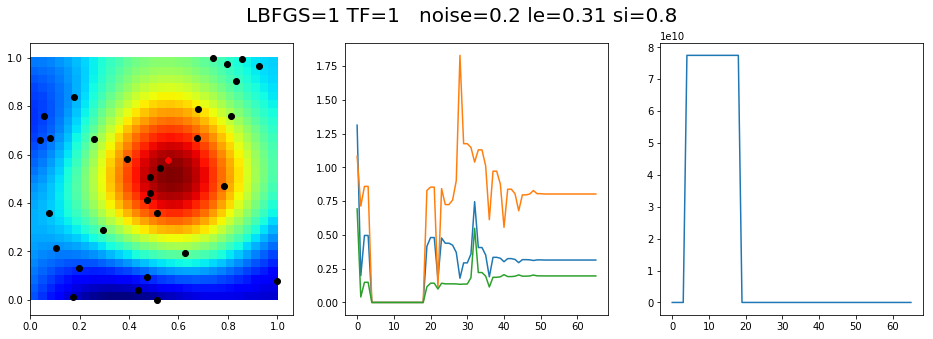

1.303759    1.073936    0.686731    41.350470
1.288902    1.061633    0.677601    41.242512
1.273584    1.051237    0.670058    41.147861
1.257791    1.043647    0.664299    41.059172
1.241581    1.039796    0.659968    40.969159
1.224984    1.040890    0.656393    40.871596
1.207957    1.048374    0.652822    40.759385
1.190379    1.063144    0.648576    40.622370
1.172083    1.084444    0.643131    40.447488
1.152910    1.110261    0.636179    40.220674
1.132760    1.138762    0.627614    39.927298
1.111604    1.168846    0.617419    39.550960
1.089481    1.199946    0.605585    39.072290
1.066483    1.231772    0.592118    38.468496
1.042749    1.264149    0.577083    37.714084
1.018459    1.296927    0.560659    36.783374
0.993841    1.329928    0.543151    35.655300
0.969157    1.362929    0.524965    34.320070
0.944697    1.395654    0.506542    32.785637
0.920748    1.427798    0.488300    31.080867
0.897571    1.459049    0.470583    29.253147
0.875377    1.489125    0.453643  

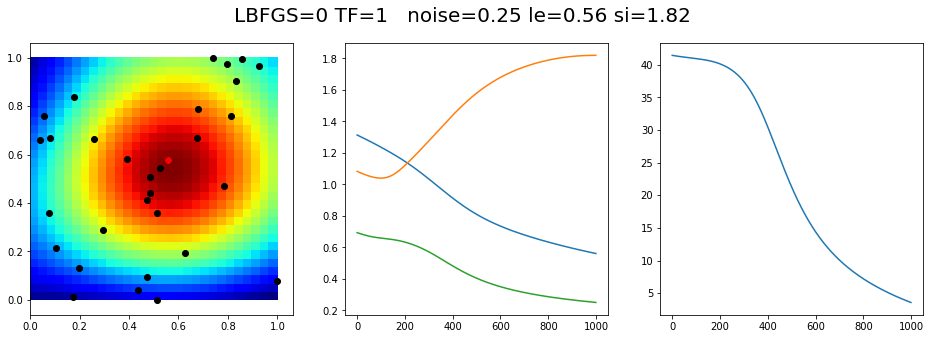

0.029971    0.489750    0.002002    38.846144
0.075077    0.682206    0.007619    16.200988
0.087074    0.631084    0.009539    13.885865
0.086727    0.609913    0.021175    13.794405
0.081286    0.258251    14.925338    196.155641
0.176052    0.686892    0.200854    2.591738
0.285686    0.777294    0.240925    -2.441729
0.314576    0.808097    0.196473    -4.052642
0.314053    0.803199    0.196413    -4.053105


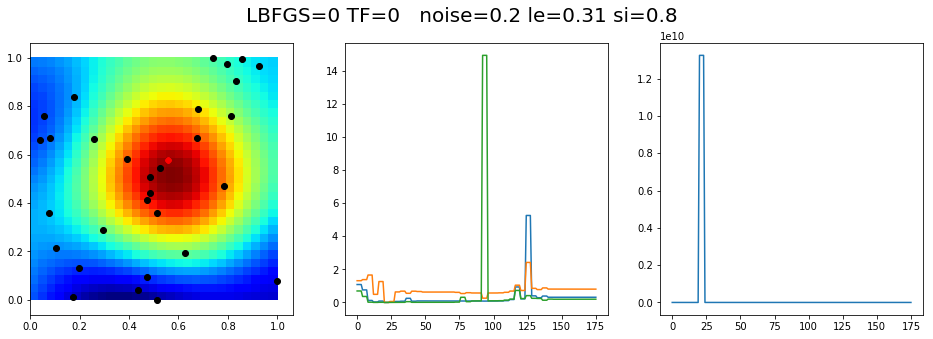

In [70]:
kernel_plot(use_tf=True, lbfgs=True)
kernel_plot(use_tf=True, lbfgs=False)
kernel_plot(use_tf=False)

In [51]:
noise = 1

params = [0.1, 0.3]#, 0.6, 0.9]

#X_train = np.array([0, 0.02, 0.05, 0.3, 0.4,1,1.1,1.2,1.3,1.4,2,3,4])

X_train = np.array([2,2.01,3], dtype=np.float64)#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
y_train = np.array([2,3,5], dtype=np.float64)

# X_train = np.array([2,2.01,2.02,3])#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
# y_train = np.array([2,3,2,100])


# y_train[1] = .6
# y_train[2] = 1

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01)

In [5]:
GaussianProcess(noise=noise, kernel=SquaredExp()).fit(X_train, y_train)\
    .optimize_kernel().posterior(X).plot_posterior(figure=False, num_samples=3)

AssertionError: X_train must be rank-2 tensor, got ndim=1

# Sklearn

1.6874958008633592 3.7416889765237187


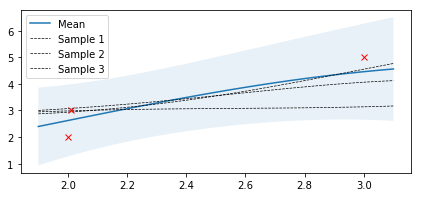

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

gpr.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

mu_s, cov_s = gpr.predict(X.reshape(-1, 1), return_cov=True)

l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
print(l, sigma_f)

plot_gp(mu_s.reshape(-1), cov_s, X, X_train, y_train, num_samples=3)

# GPy

1.558718823156942 3.844799807952893   index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.48324855  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f5b90065b00>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f5b90065a20>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f5b9006c048>]}

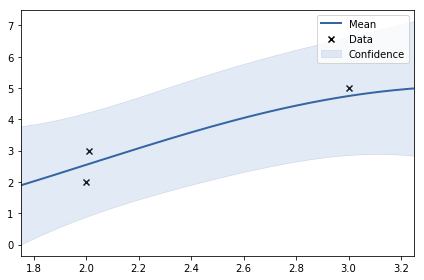

In [9]:
import GPy

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1), rbf)

#gpr.Gaussian_noise.variance = noise**2
#gpr.Gaussian_noise.variance.fix()

gpr.optimize()

l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])
print(l, sigma_f, gpr.Gaussian_noise.variance)

gpr.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f5c0810bef0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f5c0811c3c8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f5c0811c940>]}

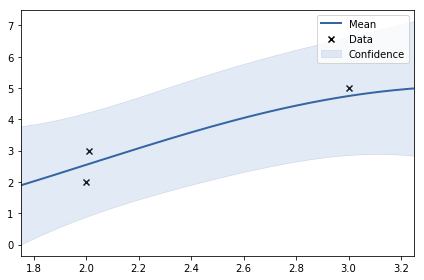

In [7]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
# kernel = GPy.kern.Matern52(input_dim=1, variance=1., lengthscale=1.)

m = GPy.models.GPRegression(X_train.reshape(-1,1),y_train.reshape(-1, 1),kernel)
m.optimize(messages=True)
m.plot()

In [10]:
rbf.K(X_train.reshape(-1, 1), X_train.reshape(-1, 1))

array([[14.78248556, 14.78218135, 12.03294434],
       [14.78218135, 14.78248556, 12.0823241 ],
       [12.03294434, 12.0823241 , 14.78248556]])

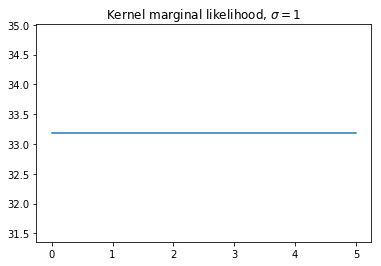

In [11]:
class GPyWrapper:
    def __init__(self):
        self.params = None
        
    def set_params(self, params):
        self.params = params
        return self
        
    def __call__(self, a, b):
        return GPy.kern.RBF(input_dim=1, variance=1., lengthscale=params[0]).K(a.reshape(-1, 1), b.reshape(-1, 1))

plot_kernel_loss(GPyWrapper(), X_train, y_train)

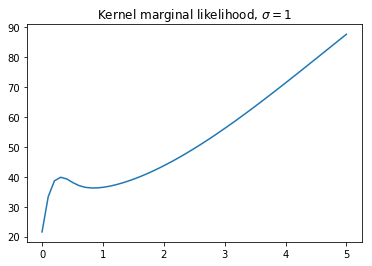

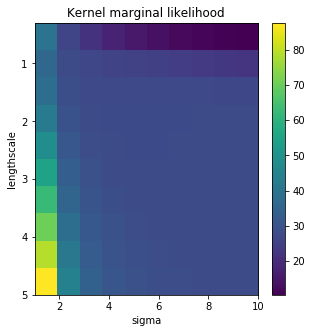

In [12]:
kernel = SquaredExp(sigma=0.001)
plot_kernel_loss(kernel, X_train, y_train)
plot_kernel_loss_2d(kernel, X_train, y_train)

# Big data

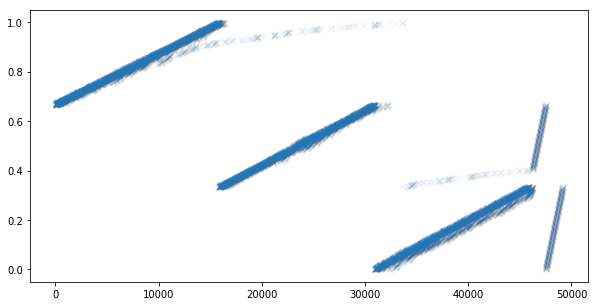

In [15]:
values = np.genfromtxt("../data/matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [16]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

In [17]:
def fit_with_scale(X, y, scale):
    y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
    X = np.array(list(range(len(y)))) / scale

    gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
    gp.plot_posterior(num_samples=0)


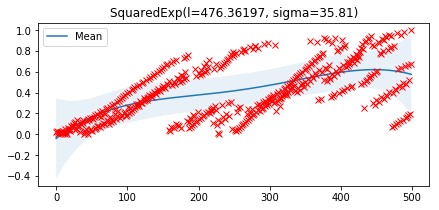

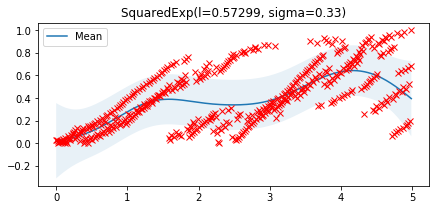

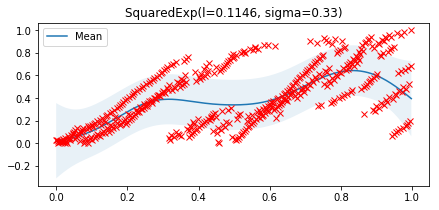

In [18]:
def foo():
    for i in [1,100, 500]:
        fit_with_scale(X, y, i)
        plt.show()
        
%prun foo()

# TODO Gaussian likelihood for a given covariance

# TODO Gaussian likelihood for a given covariance

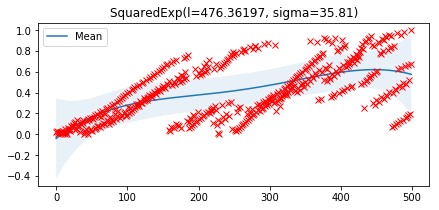

In [19]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

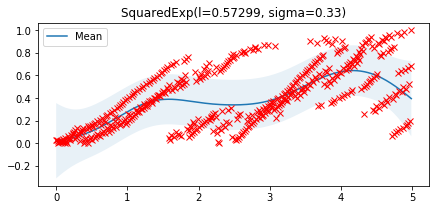

In [20]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

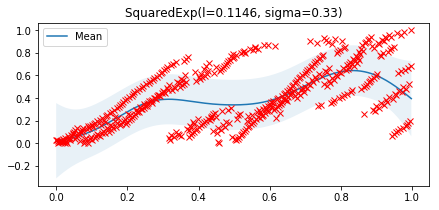

In [21]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/500

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

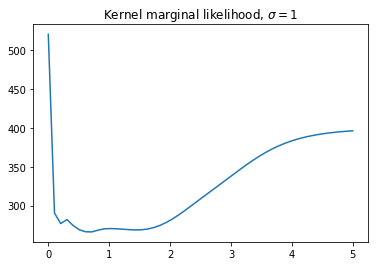

In [22]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

plot_kernel_loss(SquaredExp(), X, y)

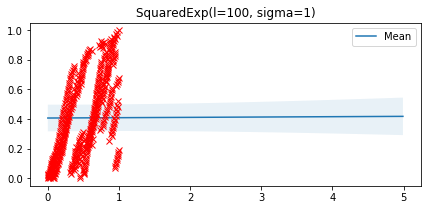

In [23]:
gp.with_kernel_params([100,1]).posterior(X).plot_posterior(num_samples=0)